<a href="https://colab.research.google.com/github/mdalarmansorker/AI-and-ML/blob/main/Vehicles_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing modules and Loading datasets***

In [2]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from glob import glob
from keras.models import Sequential
from keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from keras.callbacks import EarlyStopping,LearningRateScheduler
import warnings
from tqdm import tqdm
from PIL import Image
warnings.filterwarnings('ignore')

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='Vehicle_Detection_Image_Set.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Vehicle_Detection_Image_Set.zip')
f.keys()
!unzip Vehicle_Detection_Image_Set.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/vehicles/4414.png  
  inflating: data/vehicles/4415.png  
  inflating: data/vehicles/4416.png  
  inflating: data/vehicles/4417.png  
  inflating: data/vehicles/4418.png  
  inflating: data/vehicles/4419.png  
  inflating: data/vehicles/442.png   
  inflating: data/vehicles/4420.png  
  inflating: data/vehicles/4421.png  
  inflating: data/vehicles/4422.png  
  inflating: data/vehicles/4423.png  
  inflating: data/vehicles/4424.png  
  inflating: data/vehicles/4425.png  
  inflating: data/vehicles/4426.png  
  inflating: data/vehicles/4427.png  
  inflating: data/vehicles/4428.png  
  inflating: data/vehicles/4429.png  
  inflating: data/vehicles/443.png   
  inflating: data/vehicles/4430.png  
  inflating: data/vehicles/4431.png  
  inflating: data/vehicles/4432.png  
  inflating: data/vehicles/4433.png  
  inflating: data/vehicles/4434.png  
  inflating: data/vehicles/4435.png  
  inflating: data/vehicles/4436.png  

In [4]:
df=pd.DataFrame(columns=['image','label'])

In [5]:
# for a picture containing image of vehicle label is 1.

idx=0
for name in tqdm(glob('../content/data/vehicles/*')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[1]},index=[idx])
    df=df.append(data)    
    idx+=1

100%|██████████| 8792/8792 [00:45<00:00, 192.62it/s]


In [6]:
# for a picture doesn't contain image of vehicle label is 0.

for name in tqdm(glob('../content/data/non-vehicles/*')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[0]},index=[idx]) 
    df=df.append(data)
    idx+=1

100%|██████████| 8968/8968 [00:48<00:00, 183.42it/s]


# **Train test spliting of data**

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(df,df['label']):
    train_data=df.iloc[train_index]
    test_data=df.iloc[test_index]
# train_x,test_x,train_y,test_y=train_test_split(df['image'],df['label'],random_state=42,test_size=0.15)

In [8]:
train_img,train_label=train_data['image'],train_data['label']
test_img,test_label=test_data['image'],test_data['label']

# **Data Visualization**

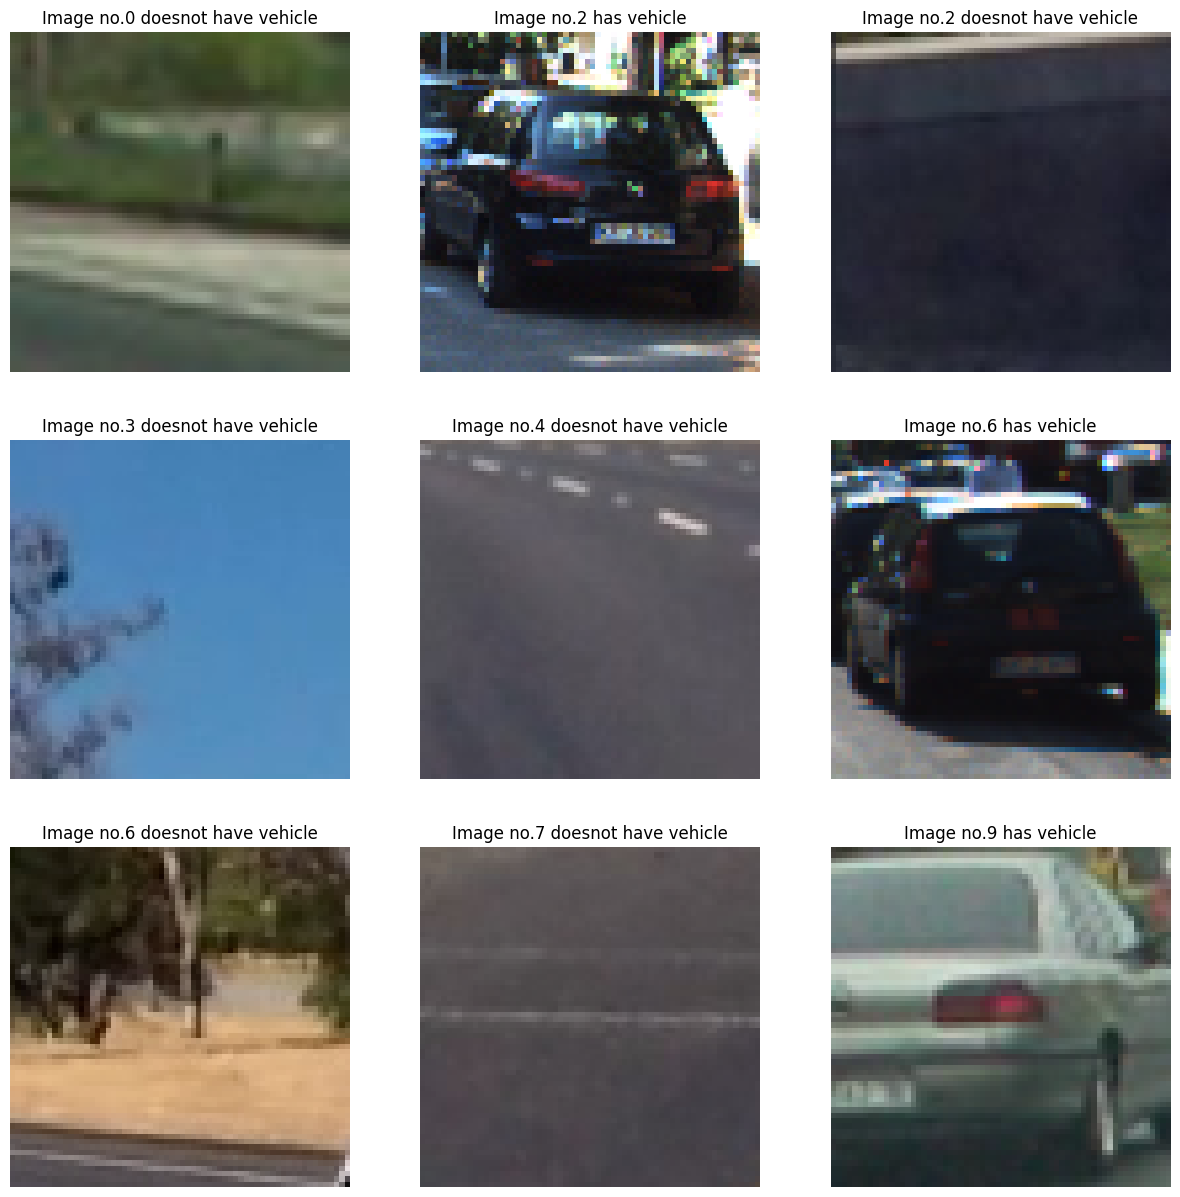

In [9]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    ix=np.random.randint(3000)
    if(train_label.iloc[ix]==1):
        plt.title('Image no.{0} has vehicle'.format(i+1))
    elif(train_label.iloc[ix]==0):
        plt.title('Image no.{0} doesnot have vehicle'.format(i))
    plt.axis('off')
    plt.imshow(train_img.iloc[ix])
plt.show()

# **Changin Dimension of Data**

In [10]:
def change_image_dimension(data):
    data=np.reshape(data.to_list(),(len(data),64,64,3))
    return data

In [11]:
train_img=change_image_dimension(train_img)
test_img=change_image_dimension(test_img)
# train_img
train_img=train_img/255.0
test_img=test_img/255.0

In [12]:
train_label=np.array(train_label,dtype=int)
test_label=np.array(test_label,dtype=int)

# **Callback Functions**

In [13]:
def schedule(epoch,lr):
    if epoch>=5:
        return 0.0001
    return 0.001
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)
learning_rate_scheduler=LearningRateScheduler(schedule)

# **Convolutional Neural Network**

In [14]:
from keras.layers import Dropout
model=Sequential()
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(64,64,3)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.add(Dropout(0.3))  # add dropout layer
model.add(Flatten())


In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
r=model.fit(train_img,train_label,validation_data=(test_img,test_label),epochs=25,batch_size=100)

Epoch 1/25
143/143 [==============================] - 18s 39ms/step - loss: 2.4517 - accuracy: 0.8007 - val_loss: 2.5007 - val_accuracy: 0.5051
Epoch 2/25
143/143 [==============================] - 4s 30ms/step - loss: 2.3050 - accuracy: 0.8373 - val_loss: 2.7435 - val_accuracy: 0.5051
Epoch 3/25
143/143 [==============================] - 5s 32ms/step - loss: 2.3939 - accuracy: 0.8332 - val_loss: 3.0962 - val_accuracy: 0.5053
Epoch 4/25
143/143 [==============================] - 5s 37ms/step - loss: 2.2945 - accuracy: 0.8468 - val_loss: 0.9681 - val_accuracy: 0.7145
Epoch 5/25
143/143 [==============================] - 4s 30ms/step - loss: 2.2988 - accuracy: 0.8453 - val_loss: 0.3308 - val_accuracy: 0.8927
Epoch 6/25
143/143 [==============================] - 4s 31ms/step - loss: 2.2593 - accuracy: 0.8509 - val_loss: 0.0560 - val_accuracy: 0.9842
Epoch 7/25
143/143 [==============================] - 4s 30ms/step - loss: 2.2816 - accuracy: 0.8504 - val_loss: 0.4241 - val_accuracy: 0.919

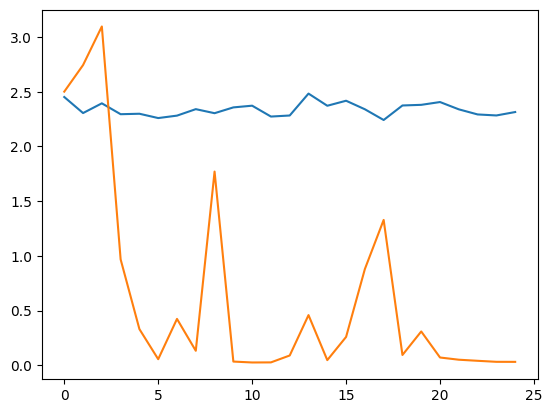

In [17]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

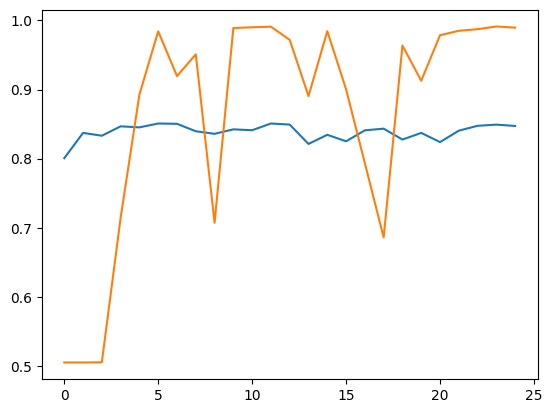

In [18]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

# **Visualization of Predicted Data**

1/1 [==============================] - 0s 28ms/step


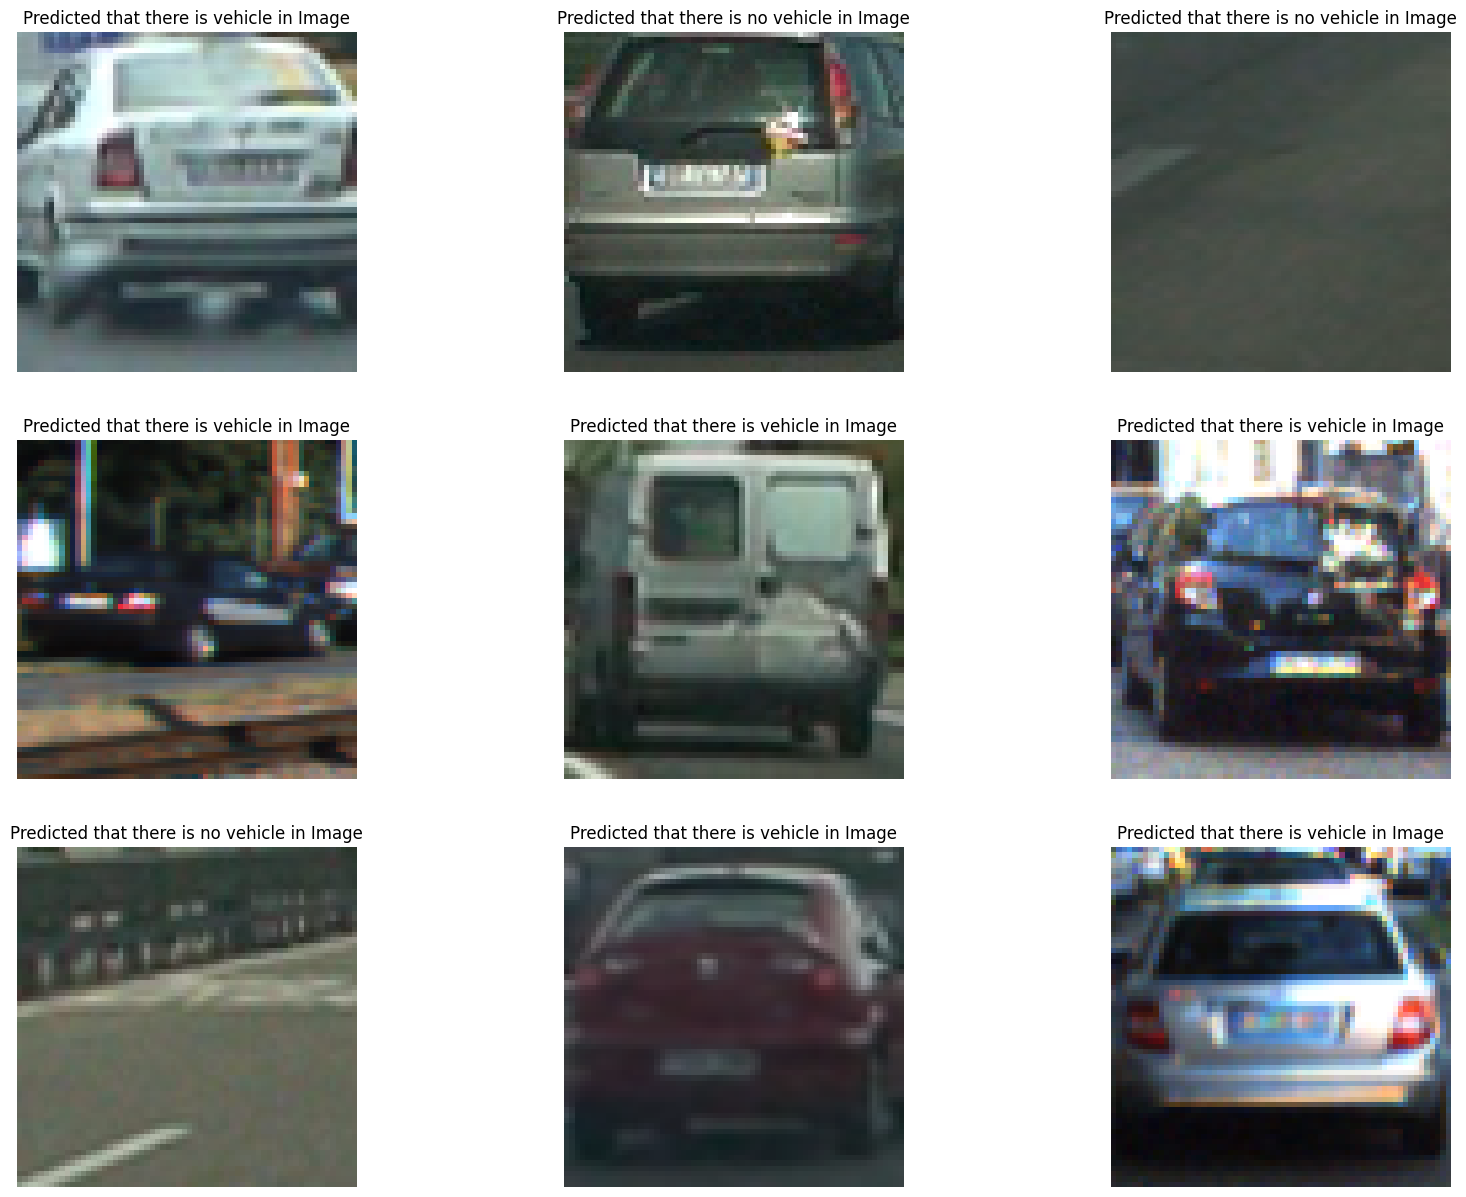

In [19]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    rd_idx=np.random.randint(700)
    pred_test=model.predict(np.reshape(test_img[rd_idx],(-1,64,64,3)))
    if pred_test>=0.99:
        plt.title('Predicted that there is vehicle in Image')
    else:
        plt.title('Predicted that there is no vehicle in Image')
    plt.axis('off')
    plt.imshow(test_img[rd_idx])
plt.show()


# **Testing by UserInput Image**

Saving eid mubarak.jpg to eid mubarak (11).jpg


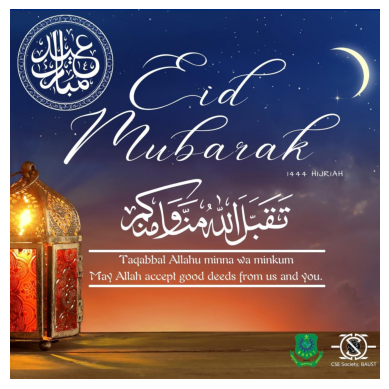

1/1 [==============================] - 0s 20ms/step
No vehicle detected in the image.


In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Define a function to preprocess the image
def preprocess_image(img_path):
  img = image.load_img(img_path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.
  return x

# Define a function to predict whether there's a vehicle in the image or not
def predict_vehicle(img_path):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  x = preprocess_image(img_path)
  prediction = model.predict(x)
  if prediction[0][0] != 1:
    print("Vehicle detected in the image!")
  else:
    print("No vehicle detected in the image.")

# Allow the user to upload an image
from google.colab import files
uploaded = files.upload()

# Call the predict_vehicle function for the uploaded image
for fn in uploaded.keys():
  path = fn
  predict_vehicle(path)
